In [1]:
import time
import os

import numpy as np

import matplotlib.pyplot as plt

import mxnet as mx
from mxnet import autograd, gluon

import gluoncv as gcv
from gluoncv.utils import download, viz

In [2]:
!ls Deep-Waldo/data

augmented.idx  combined.idx  original	train.rec  valid.rec
augmented.lst  combined.lst  train.idx	valid.idx
augmented.rec  combined.rec  train.lst	valid.lst


In [3]:
original_train_data = gcv.data.RecordFileDetection('Deep-Waldo/image_64/data/train.rec')
combined_data = gcv.data.RecordFileDetection('Deep-Waldo/image_64/data/combined.rec')

classes = ['Waldo']  # only one foreground class here

try:
#     ctx = [mx.gpu(0)] # Single gpu
    ctx = [mx.gpu(0), mx.gpu(1)] # Parallel gpu
    print('GPU Loaded')
    
except:
    ctx = [mx.cpu()]

GPU Loaded


In [4]:
net = gcv.model_zoo.get_model('ssd_512_mobilenet1.0_voc', pretrained=True)
net.reset_class(classes)

mbox_loss = gcv.loss.SSDMultiBoxLoss()
ce_metric = mx.metric.Loss('CrossEntropy')
smoothl1_metric = mx.metric.Loss('SmoothL1')

In [5]:
def get_dataloader(net, train_dataset, data_shape, batch_size, num_workers):
    
    from gluoncv.data.batchify import Tuple, Stack, Pad
    from gluoncv.data.transforms.presets.ssd import SSDDefaultTrainTransform
    width, height = data_shape, data_shape
    # use fake data to generate fixed anchors for target generation
    with autograd.train_mode():
        _, _, anchors = net(mx.nd.zeros((1, 3, height, width)))
    batchify_fn = Tuple(Stack(), Stack(), Stack())  # stack image, cls_targets, box_targets
    train_loader = gluon.data.DataLoader(
        train_dataset.transform(SSDDefaultTrainTransform(width, height, anchors)),
        batch_size, True, batchify_fn=batchify_fn, last_batch='rollover', num_workers=num_workers)
    return train_loader

# Low res - large batch (128, 32)
# High res - small batch (1024, 2)
# Medium res - medium batch (512, 8) - best so far
# High res - medium batch (1024, 16) - pretty good
# Medium res - medium batch (512, 16)
    
train_loader = get_dataloader(net, original_train_data, 256, 16, 0) # look into modifying this because what is our data sahpe?
combined_loader = get_dataloader(net, combined_data, 64, 16, 0)

save_path = './model/original_64_bs_8_ssd_waldo.params'
loader = train_loader

In [6]:
net.collect_params().reset_ctx(ctx)

########################################################
#             Tune the Hyperparameters Here            #
########################################################
learning_rate = 1e-3
num_epochs = 1000

trainer = gluon.Trainer(
    net.collect_params(), 'adam',
    {'learning_rate': learning_rate, 'wd': 0.0005})
########################################################
#             Tune the Hyperparameters Here            #
########################################################

try:
    net.load_parameters(save_path)
    print('Loading previous params')
except:
    pass


print('Training...')
cross_loss = []
l1_loss = []
for epoch in range(num_epochs):

    start_ = time.time()
    
    ce_metric.reset() 
    smoothl1_metric.reset()
    tic = time.time()
    btic = time.time()
    
    net.hybridize(static_alloc=True, static_shape=True) # look this up if you wan tot know more https://mxnet.incubator.apache.org/api/python/gluon/gluon.html?highlight=hybridize#mxnet.gluon.Block.hybridize

    cross_loss_ep, l1_loss_ep = [], []
    for i, batch in enumerate(loader):
        
        batch_size = batch[0].shape[0]
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        cls_targets = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0)
        box_targets = gluon.utils.split_and_load(batch[2], ctx_list=ctx, batch_axis=0)
        
        with autograd.record():
            
            cls_preds = []
            box_preds = []
            
            for x in data:
                
                cls_pred, box_pred, _ = net(x)
                cls_preds.append(cls_pred)
                box_preds.append(box_pred)
                
            sum_loss, cls_loss, box_loss = mbox_loss(
                cls_preds, box_preds, cls_targets, box_targets)
            
            autograd.backward(sum_loss)
        # since we have already normalized the loss, we don't want to normalize
        # by batch-size anymore
        trainer.step(1)
        ce_metric.update(0, [l * batch_size for l in cls_loss])
        smoothl1_metric.update(0, [l * batch_size for l in box_loss])
        name1, loss1 = ce_metric.get()
        name2, loss2 = smoothl1_metric.get()
        
        print('[Epoch {}][Batch {}], Speed: {:.3f} samples/sec, {}={:.3f}, {}={:.3f}'.format(
            epoch, i, batch_size/(time.time()-btic), name1, loss1, name2, loss2))
        
    cross_loss.append(loss1)
    l1_loss.append(loss2)
    if not os.path.isdir('./model'):
        os.mkdir('./model')
      
    net.save_parameters(save_path)

# Save losses
np.save('model/losses/original_64_ssd_cross_loss', cross_loss)
np.save('model/losses/original_64_ssd_l1_loss', l1_loss)

Training...
[Epoch 0][Batch 0], Speed: 5.338 samples/sec, CrossEntropy=5.933, SmoothL1=1.714
[Epoch 1][Batch 0], Speed: 40.293 samples/sec, CrossEntropy=6.427, SmoothL1=2.556
[Epoch 2][Batch 0], Speed: 50.904 samples/sec, CrossEntropy=6.135, SmoothL1=1.708
[Epoch 3][Batch 0], Speed: 50.305 samples/sec, CrossEntropy=4.410, SmoothL1=1.667
[Epoch 4][Batch 0], Speed: 49.966 samples/sec, CrossEntropy=3.715, SmoothL1=1.815
[Epoch 5][Batch 0], Speed: 46.805 samples/sec, CrossEntropy=3.186, SmoothL1=1.931
[Epoch 5][Batch 1], Speed: 24.788 samples/sec, CrossEntropy=3.261, SmoothL1=1.851
[Epoch 6][Batch 0], Speed: 46.149 samples/sec, CrossEntropy=3.191, SmoothL1=1.626
[Epoch 7][Batch 0], Speed: 48.971 samples/sec, CrossEntropy=3.074, SmoothL1=1.751
[Epoch 8][Batch 0], Speed: 47.888 samples/sec, CrossEntropy=2.962, SmoothL1=1.589
[Epoch 9][Batch 0], Speed: 52.335 samples/sec, CrossEntropy=2.733, SmoothL1=1.459
[Epoch 10][Batch 0], Speed: 48.002 samples/sec, CrossEntropy=2.546, SmoothL1=1.770
[Epo

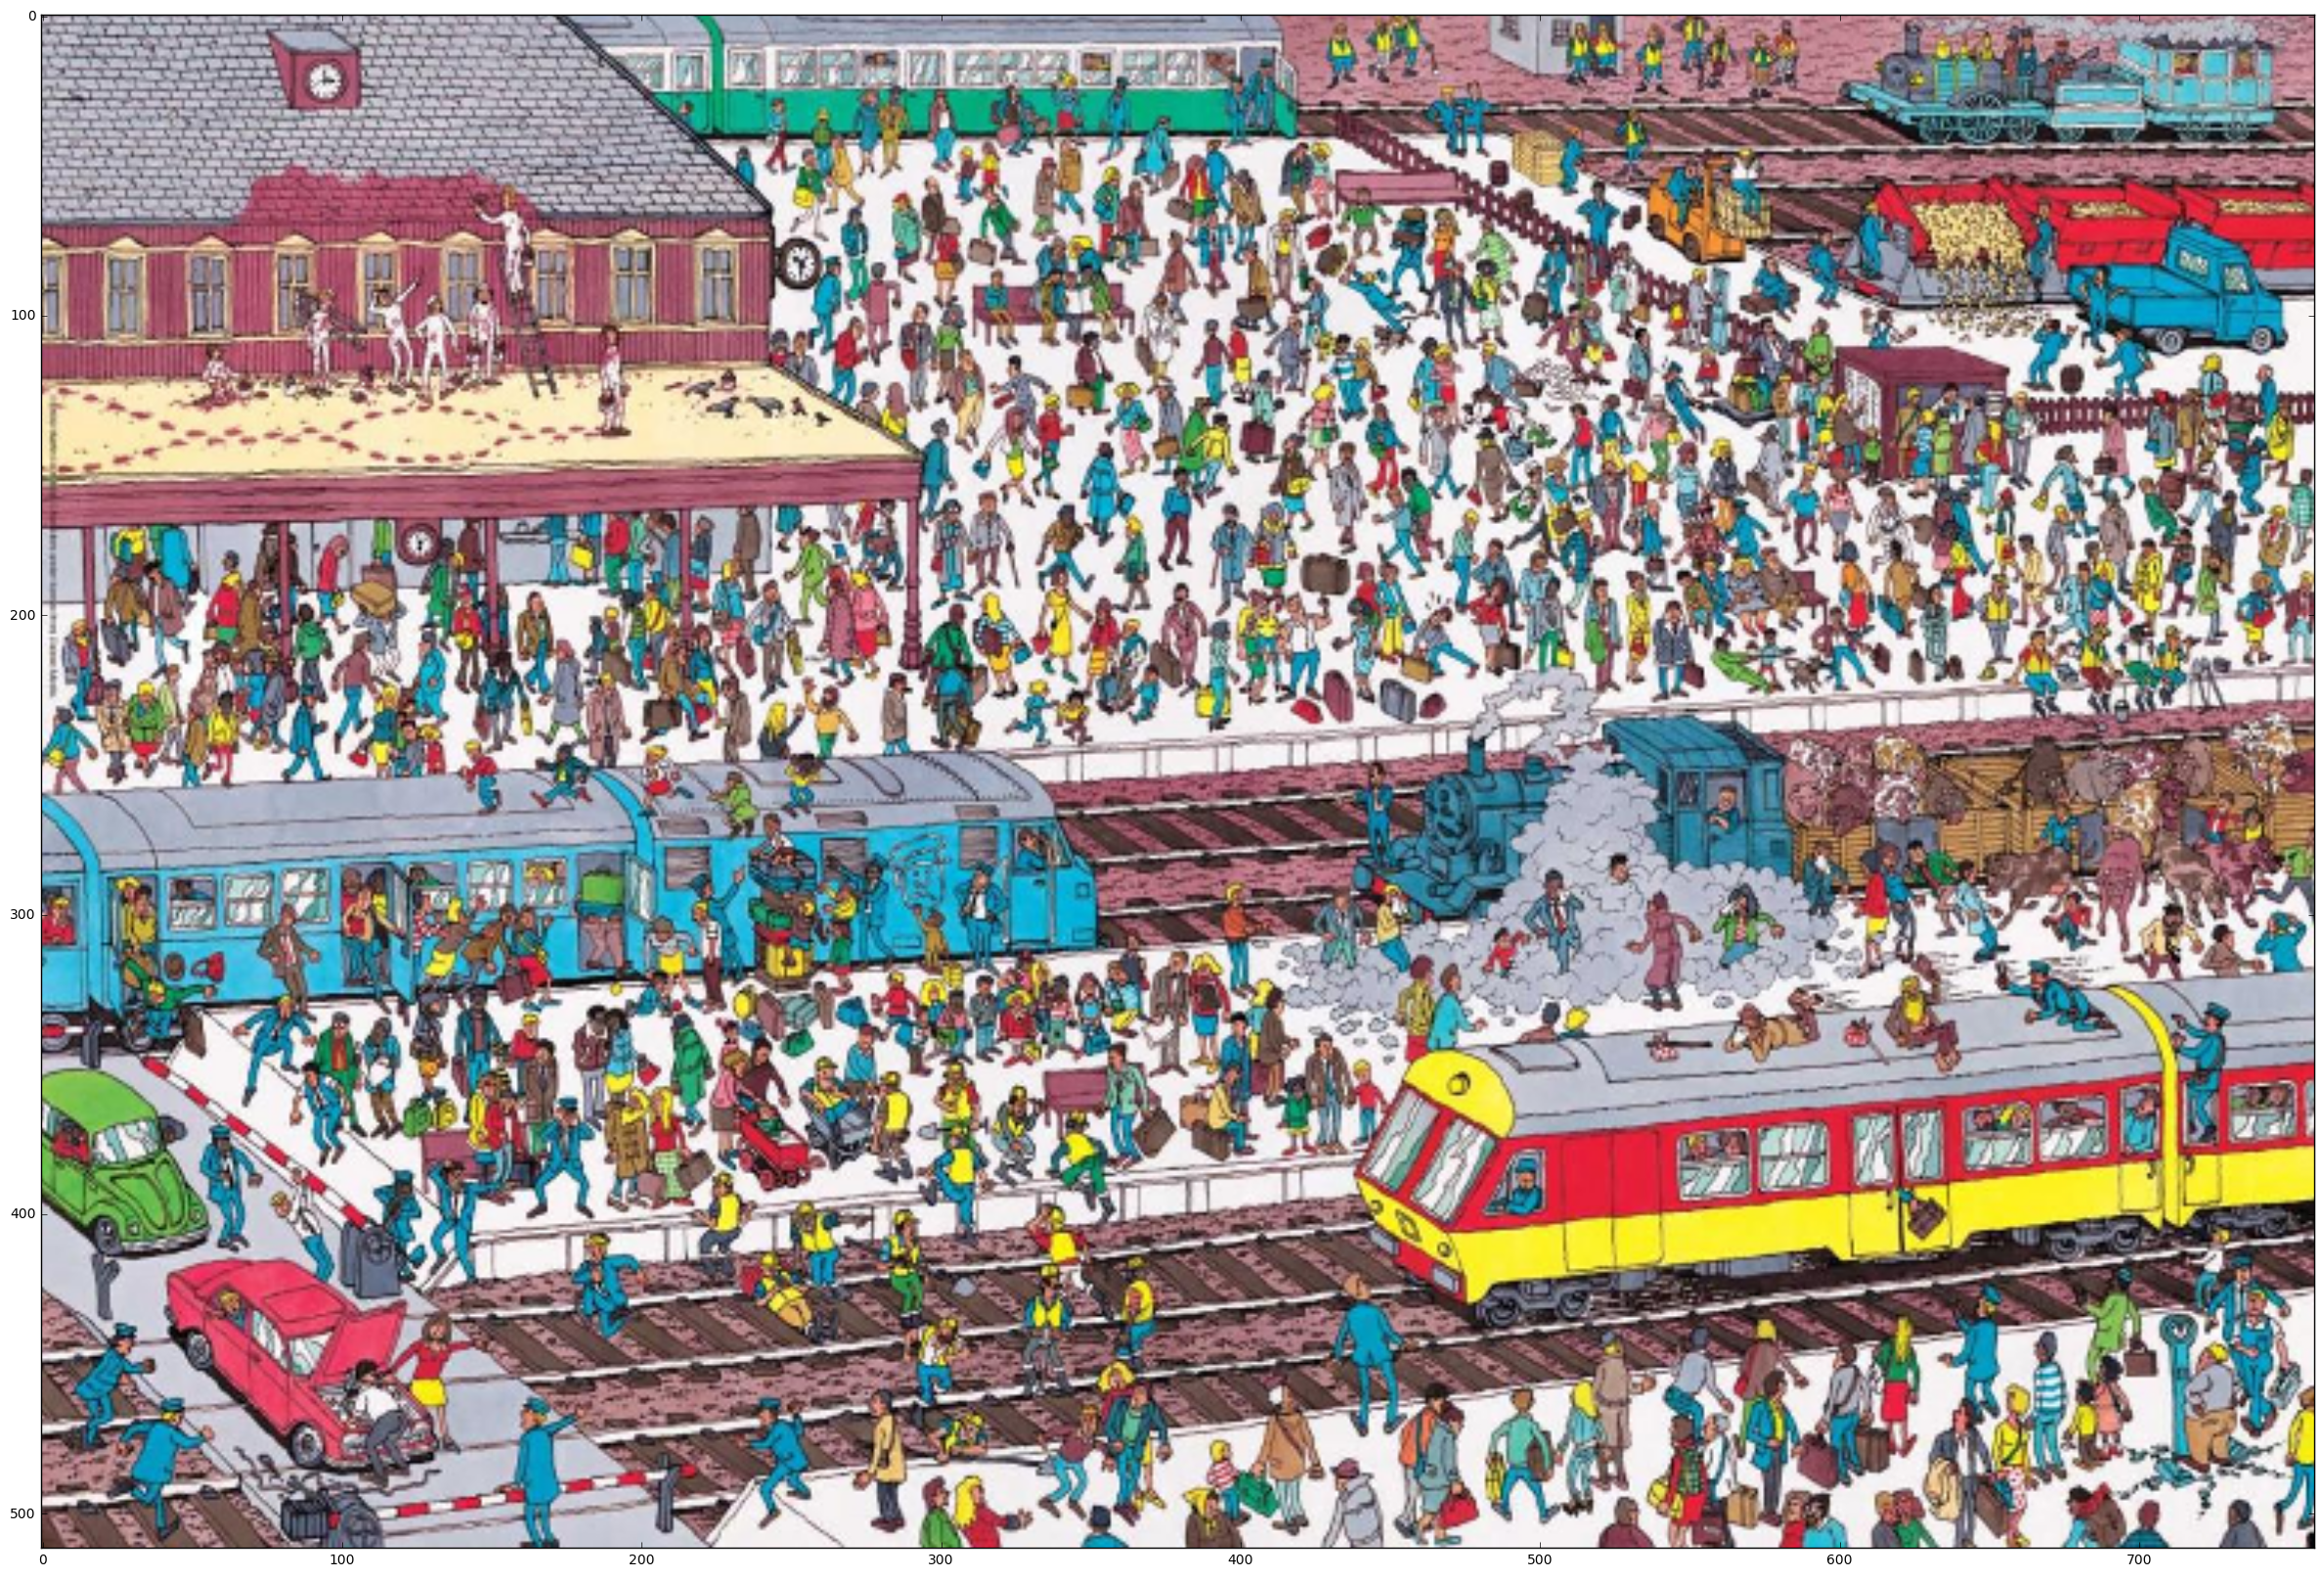

In [22]:
net = gcv.model_zoo.get_model('ssd_512_mobilenet1.0_custom', classes=classes, pretrained_base=False)
net.load_parameters(save_path, ctx=ctx)
# net.collect_params().reset_ctx(ctx)


x, image = gcv.data.transforms.presets.ssd.load_test('./Deep-Waldo/data/original/13.jpg', 512)
cid, score, bbox = net(x.as_in_context(ctx[0]))
fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(1, 1, 1)
viz.plot_bbox(image, bbox[0], score[0], cid[0], class_names=classes, ax=ax)
plt.show()

In [16]:
dir(original_train_data)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_coord_normalized',
 '_flag',
 '_record',
 '_transform',
 'filename',
 'idx_file',
 'transform',
 'transform_first']

In [ ]:
import seaborn as sns

In [ ]:
# Load in losses
saved_l1_loss = np.load('model/losses/combined_64_ssd_l1_loss.npy')
saved_cross_loss = np.load('model/losses/combined_64_ssd_cross_loss.npy')

In [ ]:
plt.ylim(0, 12)
plt.xlim(0, 1000)
sns.set(rc={'figure.figsize':(12,4)})

ax = sns.lineplot(data=saved_l1_loss, label='L1 Loss')
sns.lineplot(data=saved_cross_loss, label='Cross Loss')
ax.set_title('SSD Losses')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
plt.show()

In [ ]:
def plot_network(block, shape=(1, 3, 224, 224), save_prefix=None):
    """Plot network to visualize internal structures.

    Parameters
    ----------
    block : mxnet.gluon.HybridBlock
        A hybridizable network to be visualized.
    shape : tuple of int
        Desired input shape, default is (1, 3, 224, 224).
    save_prefix : str or None
        If not `None`, will save rendered pdf to disk with prefix.

    """
    import tempfile
    import graphviz
    if graphviz is None:
        raise RuntimeError("Cannot import graphviz.")
    if not isinstance(block, gluon.HybridBlock):
        raise ValueError("block must be HybridBlock, given {}".format(type(block)))
    data = mx.sym.var('data')
    sym = block(data)
    a = mx.viz.plot_network(sym, shape={'data':shape},
                            node_attrs={'shape':'rect', 'fixedsize':'false'})
    a.view(tempfile.mktemp('.gv'))
    if isinstance(save_prefix, str):
        a.render(save_prefix)
    return a

In [ ]:
x = plot_network(net.box_predictors[0], shape=(16,512,3,3))
x